In [1]:
import torch
import torch.nn as nn
from torch.distributions import Normal, Independent
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics import R2Score

def generate_1d_seqs(seq_length, n_samples):
    x, y = [], []
    for _ in range(n_samples):
        start = torch.rand(1).item() * 2 * torch.pi
        time_series = torch.sin(torch.linspace(start, start + seq_length * 0.1, seq_length + 1))
        x.append(time_series[:-1].unsqueeze(1))
        y.append(time_series[-1].unsqueeze(0))
    return torch.stack(x), torch.stack(y)

x, y = generate_1d_seqs(seq_length=20, n_samples=1000)
print(x.shape, y.shape)

torch.Size([1000, 20, 1]) torch.Size([1000, 1])


In [2]:
# Generate some 1D sequences
n_samples, seq_length = 1000, 20
samples, _ = generate_1d_seqs(seq_length=20, n_samples=n_samples)

# Get train/test split
split_idx = int(0.8 * n_samples)
x_train, y_train = samples[:split_idx, :-1, :], samples[:split_idx, 1:, :]
x_test, y_test = samples[split_idx:, :-1, :], samples[split_idx:, 1:, :]
print(x.shape, y.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([1000, 20, 1]) torch.Size([1000, 1])
torch.Size([800, 19, 1]) torch.Size([800, 19, 1])
torch.Size([200, 19, 1]) torch.Size([200, 19, 1])


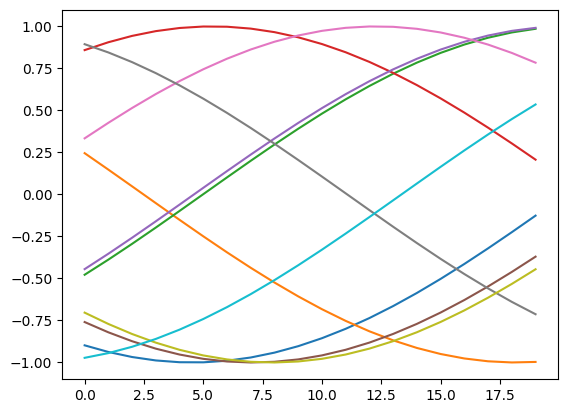

In [3]:
# Plot sample trajectories
for s in samples[:10]:
    plt.plot(s.squeeze())

In [4]:
# LSTM model with independent Normal distribution for each time step
class TrajectoryModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, 2)
        self.softplus = nn.Softplus()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.output(lstm_out)
        loc = output[..., :1]
        scale = self.softplus(output[..., 1:])
        return Independent(Normal(loc=loc, scale=scale), reinterpreted_batch_ndims=1)

In [5]:
# Plot samples
def plot_samples(model, train_split: bool = True, n_samples: int = 5):
    x, y = (x_train, y_train) if train_split else (x_test, y_test)
    seq_len = x.shape[1] + 1
    for i in range(n_samples):   
        outputs = model(x[i, :, :])
        mean = outputs.mean[:, 0].detach().numpy()
        std = outputs.stddev[:, 0].detach().numpy()
        plt.plot(np.arange(1, seq_len), y[i].squeeze(), label="GT", color="C0")
        plt.plot(np.arange(1, seq_len), mean, label="Prediction", color="C1")
        plt.fill_between(
            np.arange(1, seq_len),
            mean - std,
            mean + std,
            alpha=0.5,
            color="C1",
            lw = 0
        )
        plt.legend()
        plt.show()        

In [6]:
# Predict the next time step
model = TrajectoryModel(input_size=1, hidden_size=32)

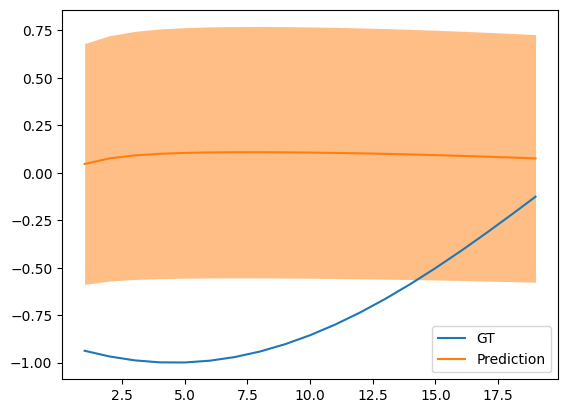

In [7]:
# Plot samples before training
plot_samples(model, train_split=True, n_samples=1)

In [8]:
# Train model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 400
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = -outputs.log_prob(y_train).sum(1).mean(0)
    loss.backward()
    optimizer.step()
    if epoch % int(0.1 * epochs) == 0:        
        r2_score = R2Score()
        r2_score.update(y_train.squeeze(), outputs.mean.squeeze())
        r2 = r2_score.compute()
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}, R2: {r2:.4f}")

Epoch 0, Loss: 21.598677, R2: -494.3750
Epoch 40, Loss: -16.168188, R2: 0.8871
Epoch 80, Loss: -9.428595, R2: 0.9398
Epoch 120, Loss: -31.102198, R2: 0.9820
Epoch 160, Loss: -11.201011, R2: 0.9765
Epoch 200, Loss: -22.805220, R2: 0.9869
Epoch 240, Loss: -4.549469, R2: 0.9122
Epoch 280, Loss: -10.141718, R2: 0.9906
Epoch 320, Loss: -23.994299, R2: 0.9913
Epoch 360, Loss: -37.531052, R2: 0.9961


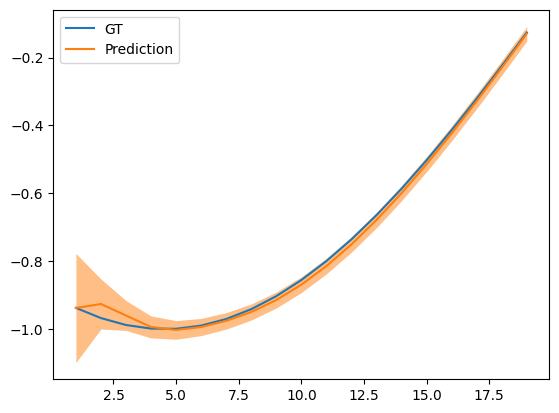

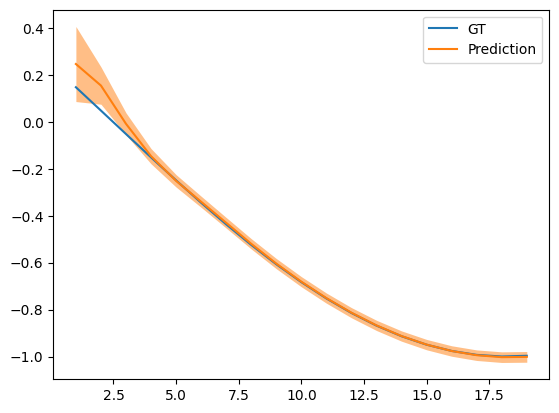

In [9]:
# Train examples
plot_samples(model, train_split=True, n_samples=2)

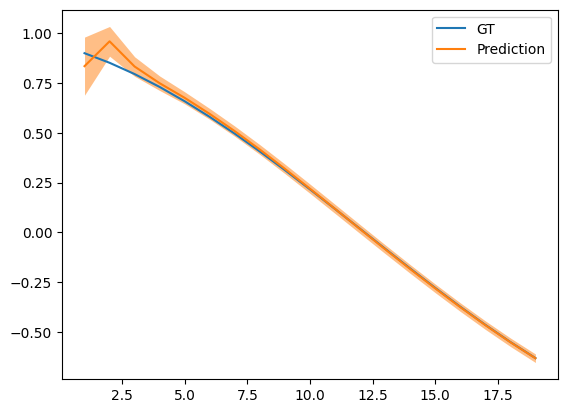

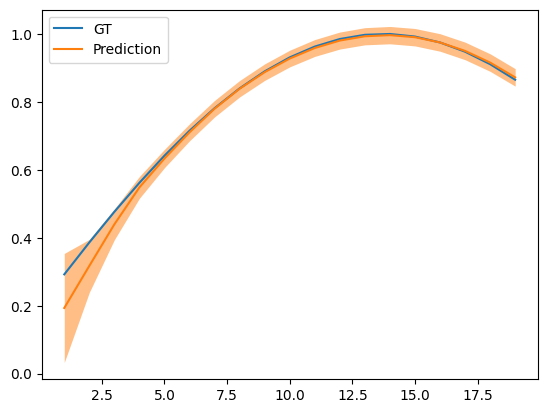

In [10]:
# Test examples
plot_samples(model, train_split=False, n_samples=2)